In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

# Import v2 modules with abbreviated names
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf
import src.ensembles_v2 as ens
import src.Birch_Murnaghan2 as bm
import src.entropy as ent
import quests

# Set random seed for reproducibility
np.random.seed(42)

folder_path = "data/all_sizes"
vasp24 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_24')]
vasp36 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_36')]
vasp48 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_48')]
vaspall = [f for f in os.listdir(folder_path) if f.startswith('SiO2')]
struct_ids = [f.replace('.vasp', '') for f in vaspall]
struct_ids_24 = [f.replace('.vasp', '') for f in vasp24]
struct_ids_36 = [f.replace('.vasp', '') for f in vasp36]
struct_ids_48 = [f.replace('.vasp', '') for f in vasp48]

struct_ids_36.sort()
struct_ids_24.sort()
struct_ids_48.sort()
struct_ids.sort()   

In [2]:
from pymatgen.io.ase import AseAtomsAdaptor
from quests import entropy, descriptor
from src.data_management_v2 import load_structures, load_energies
import numpy as np

def compute_entropy_for_ids(struct_ids, k_neighbors=32, cutoff=5.0, bandwidth=0.015):
    structures_dict = load_structures(struct_ids)
    valid_ids = [sid for sid in struct_ids if sid in structures_dict]
    
    adaptor = AseAtomsAdaptor()
    atoms_list = [adaptor.get_atoms(structures_dict[sid]) for sid in valid_ids]
    
    descriptors = descriptor.get_descriptors(atoms_list, k=k_neighbors, cutoff=cutoff, concat=True)
    
    env_counts = [len(a) for a in atoms_list]
    delta_H_values = []
    start_idx = 0
    for count in env_counts:
        end_idx = start_idx + count
        struct_desc = descriptors[start_idx:end_idx]
        ref_indices = list(range(0, start_idx)) + list(range(end_idx, len(descriptors)))
        ref_desc = descriptors[ref_indices]
        dH = entropy.delta_entropy(struct_desc, ref_desc, h=bandwidth)
        delta_H_values.append(np.mean(dH))
        start_idx = end_idx
    
    energies_dict = load_energies(valid_ids)
    energies = np.array([energies_dict.get(sid, np.nan) for sid in valid_ids])
    
    return valid_ids, np.array(delta_H_values), energies

results_24 = compute_entropy_for_ids(struct_ids_24)
results_36 = compute_entropy_for_ids(struct_ids_36)
results_48 = compute_entropy_for_ids(struct_ids_48)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


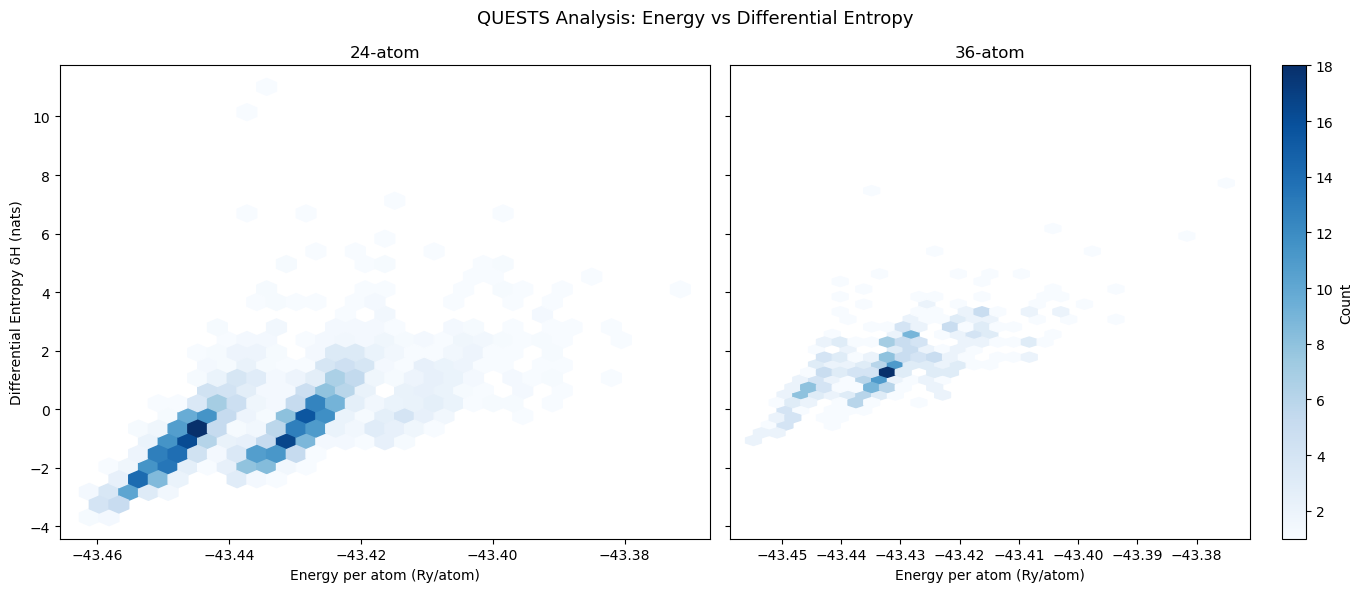

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

datasets = [results_24, results_36]
titles = ['24-atom', '36-atom']
atom_counts = [24, 36]

for ax, (valid_ids, delta_H, energies), title, n_atoms in zip(axes, datasets, titles, atom_counts):
    valid = ~np.isnan(energies)
    e_per_atom = energies[valid] / n_atoms
    ax.hexbin(e_per_atom, delta_H[valid], gridsize=30, cmap='Blues', mincnt=1)
    ax.set_xlabel('Energy per atom (Ry/atom)')
    ax.set_title(title)

axes[0].set_ylabel('Differential Entropy δH (nats)')
cb = plt.colorbar(axes[-1].collections[0], ax=axes[-1])
cb.set_label('Count')
plt.suptitle('QUESTS Analysis: Energy vs Differential Entropy', fontsize=13)
plt.tight_layout()
plt.show()

Low energy group:  1336 structures
High energy group: 1577 structures


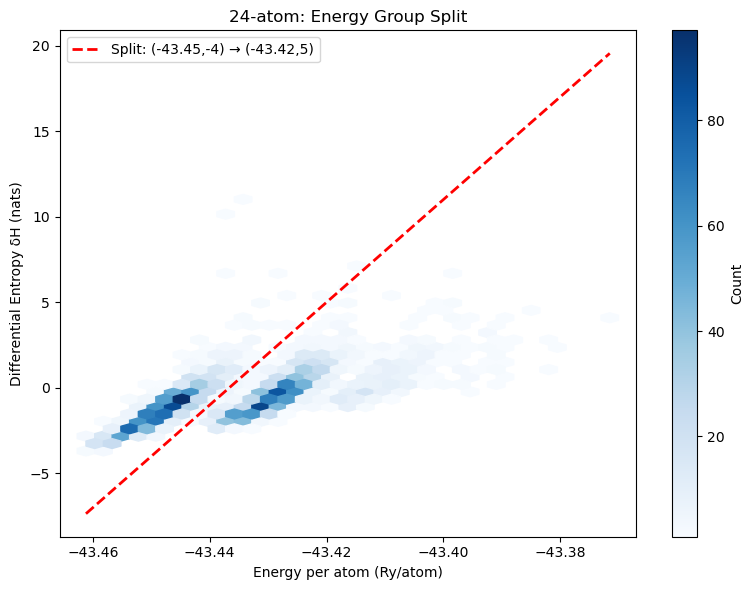

In [4]:
# Two points defining the diagonal split line
p1 = (-43.45, -4)
p2 = (-43.42, 5)

# Line equation: y = m*x + b
m = (p2[1] - p1[1]) / (p2[0] - p1[0])
b = p1[1] - m * p1[0]

# Classify: below/left of line = low energy, above/right = high energy
# Rearranged: y - mx - b < 0 means below the line
valid_ids_24, delta_H_24, energies_24 = results_24
valid = ~np.isnan(energies_24)
e_per_atom = energies_24 / 24

low_energy_ids  = [sid for sid, e, dh, v in zip(valid_ids_24, e_per_atom, delta_H_24, valid)
                   if v and dh >= m * e + b]
high_energy_ids = [sid for sid, e, dh, v in zip(valid_ids_24, e_per_atom, delta_H_24, valid)
                   if v and dh < m * e + b]

print(f"Low energy group:  {len(low_energy_ids)} structures")
print(f"High energy group: {len(high_energy_ids)} structures")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hexbin(e_per_atom[valid], delta_H_24[valid], gridsize=30, cmap='Blues', mincnt=1)

x_line = np.linspace(e_per_atom[valid].min(), e_per_atom[valid].max(), 100)
ax.plot(x_line, m * x_line + b, color='red', linestyle='--', linewidth=2,
        label=f'Split: ({p1[0]},{p1[1]}) → ({p2[0]},{p2[1]})')

ax.set_xlabel('Energy per atom (Ry/atom)')
ax.set_ylabel('Differential Entropy δH (nats)')
ax.set_title('24-atom: Energy Group Split')
ax.legend()
plt.colorbar(ax.collections[0], ax=ax, label='Count')
plt.tight_layout()
plt.show()

Calculating ensemble partial RDFs: 100%|██████████| 1336/1336 [00:00<00:00, 109161.56it/s]


Calculating ensemble partial RDFs: 100%|██████████| 1577/1577 [00:00<00:00, 133813.83it/s]


Calculating ensemble partial RDFs: 100%|██████████| 1336/1336 [00:00<00:00, 135762.33it/s]


Calculating ensemble partial RDFs: 100%|██████████| 1577/1577 [00:00<00:00, 135258.63it/s]


Calculating ensemble partial RDFs: 100%|██████████| 1336/1336 [00:00<00:00, 136676.26it/s]


Calculating ensemble partial RDFs: 100%|██████████| 1577/1577 [00:00<00:00, 132090.21it/s]


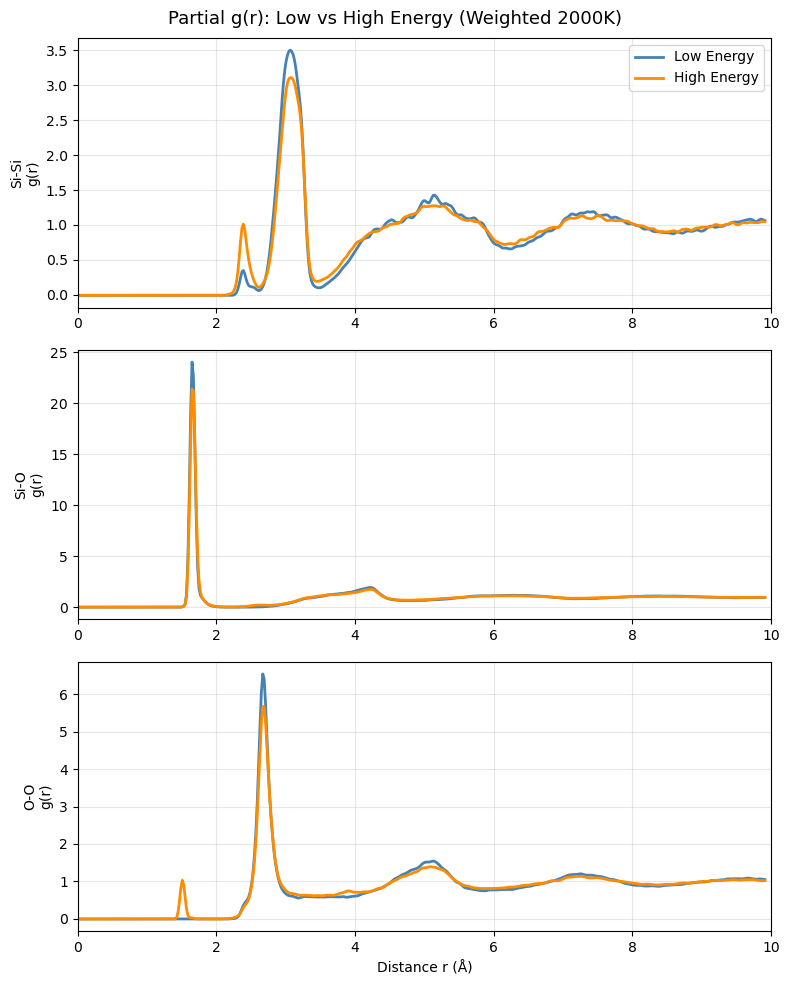

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
pairs = [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]
pair_labels = ['Si-Si', 'Si-O', 'O-O']
groups = [low_energy_ids, high_energy_ids]
labels = ['Low Energy', 'High Energy']
colors = ['steelblue', 'darkorange']

for row, (pair, pair_label) in enumerate(zip(pairs, pair_labels)):
    ax = axes[row]
    for group, label, color in zip(groups, labels, colors):
        ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
            struct_ids=group, use_weights=True, temperature=2000, smoothed=True
        )
        if pair in ensemble_rdfs:
            r, g = ensemble_rdfs[pair]
            ax.plot(r, g, color=color, linewidth=2, label=label)
    ax.set_ylabel(f'{pair_label}\ng(r)')
    ax.set_xlim(0, 10)
    ax.grid(True, alpha=0.3)
    if row == 0:
        ax.legend()
    if row == 2:
        ax.set_xlabel('Distance r (Å)')

plt.suptitle('Partial g(r): Low vs High Energy (Weighted 2000K)', fontsize=13)
plt.tight_layout()
plt.show()

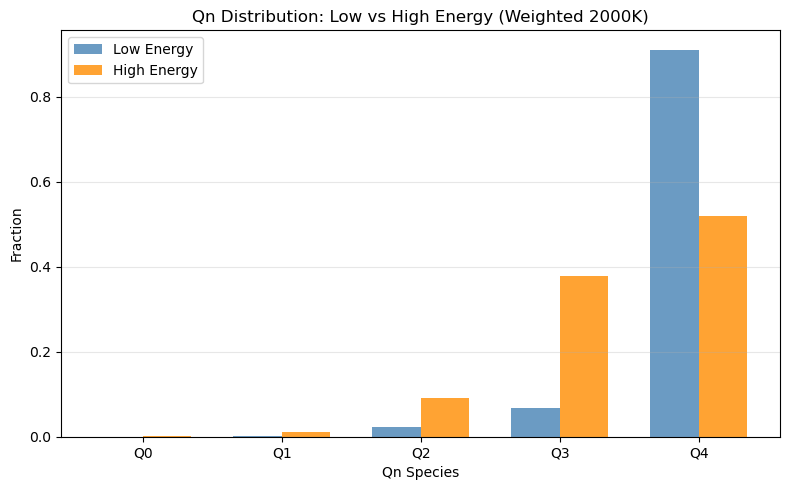

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(5)
width = 0.35

for i, (group, label, color) in enumerate(zip(groups, labels, colors)):
    qn = dm.calculate_ensemble_qn(group, use_weights=True, temperature=2000)
    values = [qn['qn_fractions'][n] for n in range(5)]
    ax.bar(x + width*(i - 0.5), values, width, label=label, color=color, alpha=0.8)

ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution: Low vs High Energy (Weighted 2000K)')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

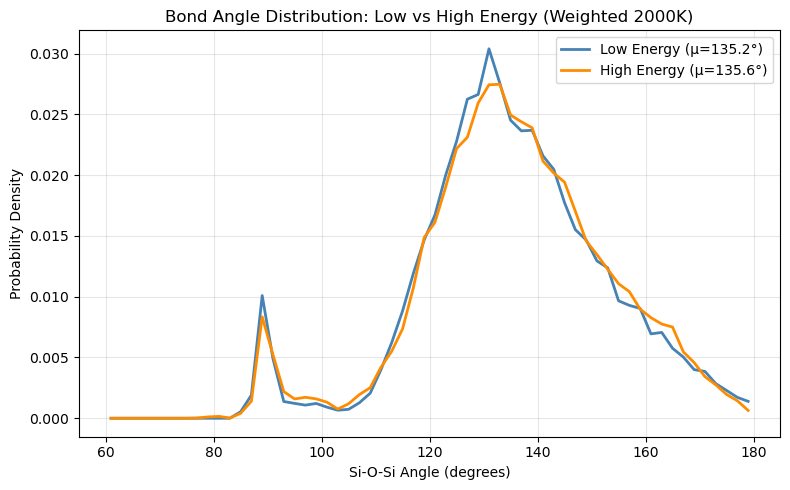

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

for group, label, color in zip(groups, labels, colors):
    result = dm.calculate_ensemble_bad(group, use_weights=True, temperature=2000)
    ax.plot(result['bin_centers'], result['histogram'], color=color, linewidth=2,
            label=f"{label} (μ={result['mean']:.1f}°)")

ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Probability Density')
ax.set_title('Bond Angle Distribution: Low vs High Energy (Weighted 2000K)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
from tqdm import tqdm
from src.rings import calculate_ring_statistics_for_structure
import pickle, os

failed = []
for struct_id in tqdm(struct_ids):
    try:
        structure, _ = dm.vasp_to_pymatgen(struct_id, "data/all_sizes")
        stats = calculate_ring_statistics_for_structure(structure)
        filepath = os.path.join('data/ring_statistics', f'{struct_id}_rings.pkl')
        with open(filepath, 'wb') as f:
            pickle.dump(stats, f)
    except Exception as e:
        failed.append((struct_id, str(e)))

print(f"Failed: {len(failed)}")
for sid, err in failed:
    print(f"  {sid}: {err}")

100%|██████████| 3478/3478 [19:25<00:00,  2.98it/s]

Failed: 21
  SiO2_24_102: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
  SiO2_24_1400: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
  SiO2_24_1645: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
  SiO2_24_1680: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
  SiO2_24_2045: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
  SiO2_24_218: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dim

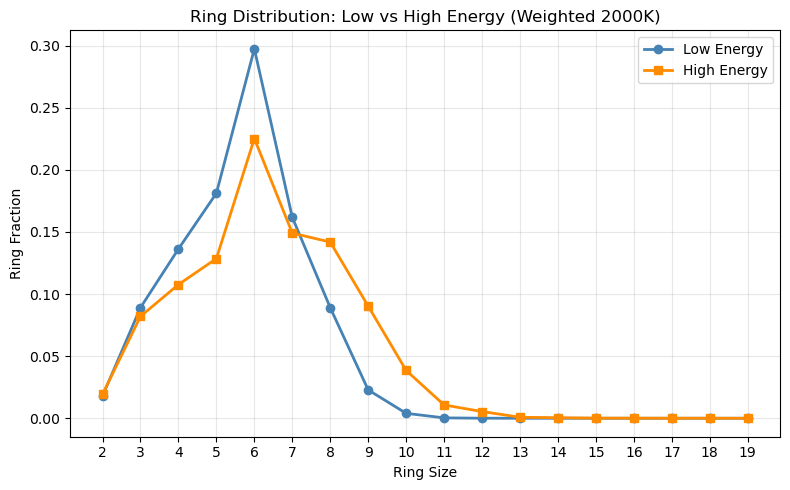

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
ring_sizes = range(2, 20)
markers = ['o', 's']

for group, label, color, marker in zip(groups, labels, colors, markers):
    result = dm.calculate_ensemble_rings(group, use_weights=True, temperature=2000)
    y = np.array([result['RN'][s] for s in ring_sizes])
    y = y / y.sum()
    ax.plot(list(ring_sizes), y, marker=marker, color=color, linewidth=2,
            markersize=6, label=label)

ax.set_xlabel('Ring Size')
ax.set_ylabel('Ring Fraction')
ax.set_title('Ring Distribution: Low vs High Energy (Weighted 2000K)')
ax.set_xticks(list(ring_sizes))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
ring_data = dm.load_ring_statistics(struct_ids_24)

large_ring_ids = {}
for sid, stats in ring_data.items():
    large_sizes = [s for s in stats['ring_sizes'] if 9 <= s <= 15]
    if large_sizes:
        large_ring_ids[sid] = large_sizes

print(f"Structures with rings of size 9-15: {len(large_ring_ids)}")
for sid, sizes in sorted(large_ring_ids.items())[:100]:
    print(f"  {sid}: {sizes}")

Structures with rings of size 9-15: 2025
  SiO2_24_1: [9, 10, 12]
  SiO2_24_100: [10, 11]
  SiO2_24_1000: [9]
  SiO2_24_1001: [9, 10]
  SiO2_24_1003: [9]
  SiO2_24_1004: [9]
  SiO2_24_1005: [9, 11]
  SiO2_24_101: [9]
  SiO2_24_1010: [9]
  SiO2_24_1011: [9, 10]
  SiO2_24_1013: [9]
  SiO2_24_1014: [9, 10]
  SiO2_24_1015: [10]
  SiO2_24_1018: [9, 10, 11]
  SiO2_24_1019: [9]
  SiO2_24_1020: [9]
  SiO2_24_1022: [9, 10]
  SiO2_24_1023: [9]
  SiO2_24_1024: [9, 10, 11]
  SiO2_24_1026: [9]
  SiO2_24_1027: [9]
  SiO2_24_1029: [9]
  SiO2_24_103: [9]
  SiO2_24_1030: [9, 10, 11]
  SiO2_24_1031: [9]
  SiO2_24_1035: [9]
  SiO2_24_1036: [10]
  SiO2_24_1037: [9]
  SiO2_24_1038: [9, 10]
  SiO2_24_1042: [9]
  SiO2_24_1043: [9, 10, 11]
  SiO2_24_1044: [9]
  SiO2_24_1045: [9, 10, 11]
  SiO2_24_1047: [9, 11]
  SiO2_24_105: [9]
  SiO2_24_1050: [9, 10, 11]
  SiO2_24_1051: [9, 10]
  SiO2_24_1052: [10, 11]
  SiO2_24_1054: [9, 10, 11, 12, 13]
  SiO2_24_1057: [9, 10, 11]
  SiO2_24_1058: [9, 10]
  SiO2_24_1059: [9

In [16]:
ring_data = dm.load_ring_statistics(struct_ids_24)

count = sum(1 for stats in ring_data.values() 
            if any(s >= 9 for s in stats['ring_sizes']))

print(f"{count} / {len(ring_data)} structures have rings of size 9+")

2027 / 2916 structures have rings of size 9+


In [20]:
from pymatgen.core import Structure
from sympy import frac
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings
import numpy as np
from collections import defaultdict

def export_ring_xyz(vasp_path, output_path, supercell=(3,3,3), max_ring_size=20):
    """
    Exports an extended XYZ file of Si AND O atoms involved in rings.
    
    Properties for OVITO coloring:
      - ring_size   : smallest ring this Si participates in (0 for O atoms)
      - is_base_cell: 1 = original unit cell atom, 0 = periodic image
    """
    struct = Structure.from_file(vasp_path)
    cutoffs = get_bond_cutoffs(struct)
    si_o_cutoff = cutoffs.get(('Si', 'O'), 2.0)
    G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
    ring_data = find_rings(G, n_base_si, max_ring_size=max_ring_size)

    # Collect Si nodes in rings -> smallest ring size
    node_to_min_ring = {}
    for ring_size, ring_key in ring_data['all_rings']:
        for node in ring_key:
            if node not in node_to_min_ring or ring_size < node_to_min_ring[node]:
                node_to_min_ring[node] = ring_size

    if not node_to_min_ring:
        print("No rings found.")
        return

    # Build supercell
    sc = struct.copy()
    sc.make_supercell(list(supercell))

    na, nb, nc = supercell
    def _is_base_cell(frac_coords):
        return (0 <= frac_coords[0] < 1/na and
                0 <= frac_coords[1] < 1/nb and
                0 <= frac_coords[2] < 1/nc)

    # For each Si in a ring, find its O neighbors and include them
    si_indices_in_rings = set(node_to_min_ring.keys())
    o_si_count = defaultdict(set)  # o_idx -> set of ring Si atoms bonded to it

    for sc_idx in si_indices_in_rings:
        site = sc[sc_idx]
        o_neighbors = sc.get_neighbors(site, si_o_cutoff)
        for o_nbr in o_neighbors:
            o_idx = o_nbr.index
            if sc[o_idx].species_string == 'O':
                o_si_count[o_idx].add(sc_idx)

    # Only keep O atoms bridging two ring Si atoms
    o_to_ring_size = {}
    for o_idx, si_set in o_si_count.items():
        if len(si_set) >= 2:
            o_to_ring_size[o_idx] = min(node_to_min_ring[s] for s in si_set)

    # Build atom list: Si first, then O
    atoms = []
    for sc_idx, min_ring in node_to_min_ring.items():
        site = sc[sc_idx]
        is_base = 1 if _is_base_cell(site.frac_coords) else 0
        atoms.append(('Si', site.coords, min_ring, is_base))

    for o_idx, min_ring in o_to_ring_size.items():
        site = sc[o_idx]
        is_base = 1 if _is_base_cell(site.frac_coords) else 0
        atoms.append(('O', site.coords, min_ring, is_base))

    # Write extended XYZ
    n = len(atoms)
    with open(output_path, 'w') as f:
        f.write(f"{n}\n")
        sc_matrix = sc.lattice.matrix  # 3x3
        lat = sc_matrix.flatten()
        lattice_str = " ".join(f"{v:.6f}" for v in lat)
        f.write(f'Lattice="{lattice_str}" Properties=species:S:1:pos:R:3:ring_size:I:1:is_base_cell:I:1 pbc="T T T"\n')
        sc_matrix_inv = np.linalg.inv(sc_matrix)
        for (species, cart, ring_size, is_base) in atoms:
            f.write(f"{species}  {cart[0]:.6f}  {cart[1]:.6f}  {cart[2]:.6f}  {ring_size}  {is_base}\n")

    print(f"Wrote {n} atoms ({len(node_to_min_ring)} Si, {len(o_to_ring_size)} O) to {output_path}")
    print(f"Ring sizes present: {sorted(set(a[2] for a in atoms if a[0]=='Si'))}")
    print(f"Base cell atoms: {sum(a[3] for a in atoms)}, Image atoms: {sum(1-a[3] for a in atoms)}")

# --- Run it ---
export_ring_xyz(
    vasp_path="data/all_sizes/SiO2_24_1045.vasp",
    output_path="data/ring_image/SiO2_24_1045.xyz",
    supercell=(3, 3, 3)
)

Wrote 140 atoms (61 Si, 79 O) to data/ring_image/SiO2_24_1045.xyz
Ring sizes present: [3, 4, 5, 6, 9, 11]
Base cell atoms: 22, Image atoms: 118


In [22]:
def get_ring_atom_coords(vasp_path, supercell=(3,3,3), max_ring_size=20):
    struct = Structure.from_file(vasp_path)
    cutoffs = get_bond_cutoffs(struct)
    G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
    ring_data = find_rings(G, n_base_si, max_ring_size=max_ring_size)

    sc = struct.copy()
    sc.make_supercell(list(supercell))

    for ring_size, ring_key in sorted(ring_data['all_rings'], key=lambda x: x[0]):
        print(f"\nRing size {ring_size} — nodes {list(ring_key)}:")
        for node in ring_key:
            coords = sc[node].coords
            print(f"  Si sc_idx={node}  cart={np.round(coords, 3)}")

get_ring_atom_coords("data/all_sizes/SiO2_24_1045.vasp", supercell=(3,3,3), max_ring_size=20)


Ring size 3 — nodes [546, 438, 567]:
  Si sc_idx=546  cart=[ 3.812 19.894  3.117]
  Si sc_idx=438  cart=[ 1.71  18.795  4.864]
  Si sc_idx=567  cart=[ 6.358 -1.087  2.61 ]

Ring size 3 — nodes [432, np.int64(570), np.int64(540)]:
  Si sc_idx=432  cart=[4.288 3.586 3.405]
  Si sc_idx=570  cart=[5.07  6.518 3.339]
  Si sc_idx=540  cart=[6.39  4.685 1.658]

Ring size 4 — nodes [np.int64(531), np.int64(489), 459, np.int64(597)]:
  Si sc_idx=531  cart=[-0.287  4.408  0.981]
  Si sc_idx=489  cart=[-0.576  5.976  5.129]
  Si sc_idx=459  cart=[-0.031  3.391  3.964]
  Si sc_idx=597  cart=[-0.51   7.241  2.238]

Ring size 4 — nodes [537, 594, 465, 486]:
  Si sc_idx=537  cart=[-2.865 19.618  2.44 ]
  Si sc_idx=594  cart=[ 0.779 -0.363  1.509]
  Si sc_idx=465  cart=[-2.609 18.6    5.423]
  Si sc_idx=486  cart=[ 0.713 -1.629  4.4  ]

Ring size 4 — nodes [432, np.int64(621), np.int64(540), 461]:
  Si sc_idx=432  cart=[4.288 3.586 3.405]
  Si sc_idx=621  cart=[2.828 2.269 0.997]
  Si sc_idx=540  car

In [ ]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider
from collections import defaultdict
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings

def visualize_rings_interactive(vasp_path, supercell=(3,3,3), max_ring_size=20):
    struct = Structure.from_file(vasp_path)
    cutoffs = get_bond_cutoffs(struct)
    si_o_cutoff = cutoffs.get(('Si', 'O'), 2.0)

    G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
    ring_data = find_rings(G, n_base_si, max_ring_size=max_ring_size)

    sc = struct.copy()
    sc.make_supercell(list(supercell))

    # Precompute coords
    all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}
    all_o_coords  = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'O'}

    # Build Si-O bonds (no PBC)
    o_to_bonded_si = defaultdict(list)
    for o_idx, o_coords in all_o_coords.items():
        for si_idx, si_coords in all_si_coords.items():
            if np.linalg.norm(si_coords - o_coords) < si_o_cutoff:
                o_to_bonded_si[o_idx].append(si_idx)

    def ring_max_jump(coords):
        """Max pairwise distance between any two Si in the ring."""
        max_d = 0
        for i in range(len(coords)):
            for j in range(i+1, len(coords)):
                d = np.linalg.norm(coords[i] - coords[j])
                if d > max_d:
                    max_d = d
        return max_d

    # Deduplicate rings by topology, keep most compact (non-wrapping) instance
    ring_by_topology = {}
    for ring_size, ring_key in ring_data['all_rings']:
        nodes = list(ring_key)
        coords = np.array([all_si_coords[n] for n in nodes])
        compactness = ring_max_jump(coords)
        topo_key = frozenset(n % n_base_si for n in nodes)
        if topo_key not in ring_by_topology or compactness < ring_by_topology[topo_key]['compactness']:
            ring_by_topology[topo_key] = {
                'size': ring_size, 'nodes': nodes,
                'coords': coords, 'centroid': coords.mean(axis=0),
                'compactness': compactness
            }
    for topo_key, ring in ring_by_topology.items():
        if ring['size'] <= 12:
            print(f"Size {ring['size']} | compactness={ring['compactness']:.2f} | centroid={np.round(ring['centroid'],2)}")
    base_rings = sorted(ring_by_topology.values(), key=lambda r: r['size'])
    print(f"Unique base-cell rings: {len(base_rings)}")

    # Precompute static bond traces
    bond_x, bond_y, bond_z = [], [], []
    for o_idx, o_coords in all_o_coords.items():
        bonded = [s for s in o_to_bonded_si[o_idx] if s in all_si_coords]
        if len(bonded) >= 2:
            for s in bonded:
                sc_coords = all_si_coords[s]
                bond_x += [sc_coords[0], o_coords[0], None]
                bond_y += [sc_coords[1], o_coords[1], None]
                bond_z += [sc_coords[2], o_coords[2], None]

    all_o_x, all_o_y, all_o_z = zip(*all_o_coords.values())

    def make_figure(ring_idx):
        ring = base_rings[ring_idx]
        ring_nodes = set(ring['nodes'])

        bg_si = [(i, c) for i, c in all_si_coords.items() if i not in ring_nodes]
        bg_x, bg_y, bg_z = zip(*[c for _, c in bg_si]) if bg_si else ([], [], [])

        rc = ring['coords']

        ring_bond_x, ring_bond_y, ring_bond_z = [], [], []
        for o_idx, o_coords in all_o_coords.items():
            ring_bonded = [s for s in o_to_bonded_si[o_idx] if s in ring_nodes]
            if len(ring_bonded) >= 2:
                for s in ring_bonded:
                    sc_coords = all_si_coords[s]
                    ring_bond_x += [sc_coords[0], o_coords[0], None]
                    ring_bond_y += [sc_coords[1], o_coords[1], None]
                    ring_bond_z += [sc_coords[2], o_coords[2], None]

        traces = [
            go.Scatter3d(x=bond_x, y=bond_y, z=bond_z, mode='lines',
                         line=dict(color='darkgrey', width=1), name='Bonds', hoverinfo='skip'),
            go.Scatter3d(x=bg_x, y=bg_y, z=bg_z, mode='markers',
                         marker=dict(size=4, color='lightgrey', opacity=0.3),
                         name='Si', hoverinfo='skip'),
            go.Scatter3d(x=all_o_x, y=all_o_y, z=all_o_z, mode='markers',
                         marker=dict(size=2, color='red', opacity=0.2),
                         name='O', hoverinfo='skip'),
            go.Scatter3d(x=ring_bond_x, y=ring_bond_y, z=ring_bond_z, mode='lines',
                         line=dict(color='steelblue', width=6), name='Ring bonds'),
            go.Scatter3d(x=rc[:,0], y=rc[:,1], z=rc[:,2], mode='markers',
                         marker=dict(size=10, color='steelblue', opacity=1.0),
                         name=f'Ring Si (size {ring["size"]})'),
        ]

        fig = go.Figure(data=traces)
        fig.update_layout(
            title=f"Ring {ring_idx+1}/{len(base_rings)} — Size {ring['size']}",
            scene=dict(aspectmode='cube'),
            height=650, margin=dict(l=0, r=0, t=40, b=0)
        )
        fig.show()

    interact(make_figure, ring_idx=IntSlider(min=0, max=len(base_rings)-1, step=1, description='Ring'))

# --- Run ---
visualize_rings_interactive("data/all_sizes/SiO2_24_1045.vasp")

Size 4 | compactness=4.20 | centroid=[0.79 4.41 5.54]
Size 11 | compactness=39.85 | centroid=[8.22 6.03 7.06]
Size 7 | compactness=14.42 | centroid=[2.01 3.23 6.1 ]
Size 4 | compactness=21.63 | centroid=[-1.    9.06  3.44]
Size 5 | compactness=5.34 | centroid=[0.01 3.47 5.78]
Size 3 | compactness=21.14 | centroid=[ 3.96 12.53  3.53]
Size 4 | compactness=17.99 | centroid=[1.45 2.75 4.52]
Size 4 | compactness=25.36 | centroid=[-5.79  7.23  8.48]
Size 10 | compactness=25.36 | centroid=[0.45 8.58 4.15]
Size 11 | compactness=11.00 | centroid=[6.04 2.76 5.15]
Size 11 | compactness=26.02 | centroid=[5.22 7.6  5.62]
Size 11 | compactness=25.99 | centroid=[7.03 2.55 6.27]
Size 4 | compactness=4.35 | centroid=[0.49 2.39 5.53]
Size 3 | compactness=3.03 | centroid=[5.25 4.93 2.8 ]
Size 5 | compactness=16.97 | centroid=[1.55 4.06 4.17]
Size 11 | compactness=33.87 | centroid=[9.   1.54 6.43]
Size 9 | compactness=25.36 | centroid=[-1.4   8.46  5.19]
Size 6 | compactness=26.33 | centroid=[-2.17  7.96 

interactive(children=(IntSlider(value=0, description='Ring', max=22), Output()), _dom_classes=('widget-interac…

In [37]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, Dropdown
from collections import defaultdict
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings

def visualize_rings_per_atom(vasp_path, supercell=(3,3,3), max_ring_size=20, max_compactness=55):
    struct = Structure.from_file(vasp_path)
    cutoffs = get_bond_cutoffs(struct)
    si_o_cutoff = cutoffs.get(('Si', 'O'), 2.0)

    G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
    ring_data = find_rings(G, n_base_si, max_ring_size=max_ring_size)

    sc = struct.copy()
    sc.make_supercell(list(supercell))

    na, nb, nc = supercell
    def _is_base_cell(fc):
        return (0 <= fc[0] < 1/na and 0 <= fc[1] < 1/nb and 0 <= fc[2] < 1/nc)

    all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}
    all_o_coords  = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'O'}

    # Identify base-cell Si nodes by fractional coords
    base_node_ids = [i for i in all_si_coords if _is_base_cell(sc[i].frac_coords)]
    print(f"Base cell Si atoms: {len(base_node_ids)}")

    # Build Si-O bonds (no PBC)
    o_to_bonded_si = defaultdict(list)
    for o_idx, o_coords in all_o_coords.items():
        for si_idx, si_coords in all_si_coords.items():
            if np.linalg.norm(si_coords - o_coords) < si_o_cutoff:
                o_to_bonded_si[o_idx].append(si_idx)

    def ring_max_jump(coords):
        max_d = 0
        for i in range(len(coords)):
            for j in range(i+1, len(coords)):
                d = np.linalg.norm(coords[i] - coords[j])
                if d > max_d:
                    max_d = d
        return max_d

    # Build per-ring info
    all_rings_info = []
    for ring_size, ring_key in ring_data['all_rings']:
        nodes = list(ring_key)
        coords = np.array([all_si_coords[n] for n in nodes])
        compactness = ring_max_jump(coords)
        all_rings_info.append({
            'size': ring_size,
            'nodes': nodes,
            'node_set': set(nodes),
            'coords': coords,
            'centroid': coords.mean(axis=0),
            'compactness': compactness
        })

    # For each base-cell Si, collect its rings (deduplicated, non-wrapping)
    atom_rings = {}
    for node in base_node_ids:
        candidate_rings = [r for r in all_rings_info if node in r['node_set']]

        topo_best = {}
        for r in candidate_rings:
            topo_key = frozenset(n % n_base_si for n in r['nodes'])
            if topo_key not in topo_best or r['compactness'] < topo_best[topo_key]['compactness']:
                topo_best[topo_key] = r

        valid = sorted(
            [r for r in topo_best.values() if r['compactness'] <= max_compactness],
            key=lambda r: r['size']
        )
        atom_rings[node] = valid

    # Precompute static bond traces
    bond_x, bond_y, bond_z = [], [], []
    for o_idx, o_coords in all_o_coords.items():
        bonded = [s for s in o_to_bonded_si[o_idx] if s in all_si_coords]
        if len(bonded) >= 2:
            for s in bonded:
                c = all_si_coords[s]
                bond_x += [c[0], o_coords[0], None]
                bond_y += [c[1], o_coords[1], None]
                bond_z += [c[2], o_coords[2], None]

    all_o_x, all_o_y, all_o_z = zip(*all_o_coords.values())

    # Dropdown options — one per base-cell Si atom
    atom_options = {f"Si {idx} — node {node} ({len(atom_rings[node])} rings)": node
                    for idx, node in enumerate(base_node_ids)}

    def make_figure(atom_label, ring_idx):
        node = atom_options[atom_label]
        rings = atom_rings[node]
        focal_coords = all_si_coords[node]

        if not rings:
            print("No valid rings found for this atom.")
            return

        ring_idx_clamped = min(ring_idx, len(rings) - 1)
        ring = rings[ring_idx_clamped]
        ring_nodes = set(ring['nodes'])
        rc = ring['coords']

        # Ring bonds
        ring_bond_x, ring_bond_y, ring_bond_z = [], [], []
        for o_idx, o_coords in all_o_coords.items():
            ring_bonded = [s for s in o_to_bonded_si[o_idx] if s in ring_nodes]
            if len(ring_bonded) >= 2:
                for s in ring_bonded:
                    c = all_si_coords[s]
                    ring_bond_x += [c[0], o_coords[0], None]
                    ring_bond_y += [c[1], o_coords[1], None]
                    ring_bond_z += [c[2], o_coords[2], None]

        bg_si = [(i, c) for i, c in all_si_coords.items()
                 if i not in ring_nodes and i != node]
        bg_x, bg_y, bg_z = zip(*[c for _, c in bg_si]) if bg_si else ([], [], [])

        traces = [
            go.Scatter3d(x=bond_x, y=bond_y, z=bond_z, mode='lines',
                         line=dict(color='darkgrey', width=1), name='Bonds', hoverinfo='skip'),
            go.Scatter3d(x=bg_x, y=bg_y, z=bg_z, mode='markers',
                         marker=dict(size=4, color='lightgrey', opacity=0.3),
                         name='Si', hoverinfo='skip'),
            go.Scatter3d(x=all_o_x, y=all_o_y, z=all_o_z, mode='markers',
                         marker=dict(size=2, color='red', opacity=0.2),
                         name='O', hoverinfo='skip'),
            go.Scatter3d(x=ring_bond_x, y=ring_bond_y, z=ring_bond_z, mode='lines',
                         line=dict(color='steelblue', width=6), name='Ring bonds'),
            go.Scatter3d(x=rc[:,0], y=rc[:,1], z=rc[:,2], mode='markers',
                         marker=dict(size=8, color='steelblue', opacity=1.0),
                         name=f'Ring Si (size {ring["size"]})'),
            go.Scatter3d(x=[focal_coords[0]], y=[focal_coords[1]], z=[focal_coords[2]],
                         mode='markers',
                         marker=dict(size=14, color='orange', opacity=1.0),
                         name='Focal Si'),
        ]

        fig = go.Figure(data=traces)
        fig.update_layout(
            title=f"{atom_label} | Ring {ring_idx_clamped+1}/{len(rings)} — Size {ring['size']}",
            scene=dict(aspectmode='cube'),
            height=650, margin=dict(l=0, r=0, t=40, b=0)
        )
        fig.show()

    interact(
        make_figure,
        atom_label=Dropdown(options=list(atom_options.keys()), description='Atom'),
        ring_idx=IntSlider(min=0, max=10, step=1, description='Ring')
    )

# --- Run ---
visualize_rings_per_atom("data/all_sizes/SiO2_24_1045.vasp")

Base cell Si atoms: 8


interactive(children=(Dropdown(description='Atom', options=('Si 0 — node 432 (6 rings)', 'Si 1 — node 459 (4 r…

In [39]:
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings
import numpy as np
from collections import defaultdict

vasp_path = "data/all_sizes/SiO2_24_1045.vasp"
supercell = (3,3,3)

struct = Structure.from_file(vasp_path)
cutoffs = get_bond_cutoffs(struct)
G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
ring_data = find_rings(G, n_base_si, max_ring_size=20)

sc = struct.copy()
sc.make_supercell(list(supercell))
all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}

def ring_max_jump(coords):
    return max(np.linalg.norm(coords[i]-coords[j])
               for i in range(len(coords)) for j in range(i+1, len(coords)))

all_rings_info = []
for ring_size, ring_key in ring_data['all_rings']:
    nodes = list(ring_key)
    coords = np.array([all_si_coords[n] for n in nodes])
    all_rings_info.append({
        'size': ring_size,
        'nodes': nodes,
        'node_set': set(nodes),
        'coords': coords,
        'compactness': ring_max_jump(coords)
    })

for debug_node in [621, 567]:
    print(f"\n{'='*50}")
    print(f"Node {debug_node} | n_base_si={n_base_si}")
    candidate_rings = [r for r in all_rings_info if debug_node in r['node_set']]
    print(f"Total rings containing this node: {len(candidate_rings)}")

    for r in sorted(candidate_rings, key=lambda x: x['size']):
        base_indices = sorted([n % n_base_si for n in r['nodes']])
        print(f"  Size {r['size']} | compactness={r['compactness']:.2f} | base_indices={base_indices}")


Node 621 | n_base_si=8
Total rings containing this node: 8
  Size 4 | compactness=17.99 | base_indices=[0, np.int64(4), np.int64(5), 5]
  Size 5 | compactness=16.97 | base_indices=[0, np.int64(2), np.int64(3), np.int64(5), 5]
  Size 8 | compactness=17.99 | base_indices=[0, 1, 2, np.int64(4), 5, np.int64(5), np.int64(5), np.int64(6)]
  Size 9 | compactness=25.36 | base_indices=[0, 0, np.int64(0), np.int64(3), np.int64(3), 3, 5, np.int64(5), 6]
  Size 10 | compactness=25.36 | base_indices=[0, 0, np.int64(0), 0, np.int64(2), 3, np.int64(3), 3, 5, 6]
  Size 10 | compactness=21.81 | base_indices=[0, np.int64(0), 0, np.int64(3), np.int64(3), 5, np.int64(5), 6, 6, np.int64(7)]
  Size 11 | compactness=11.00 | base_indices=[0, 0, 0, 2, np.int64(2), np.int64(3), np.int64(3), np.int64(5), np.int64(5), 5, 7]
  Size 11 | compactness=25.36 | base_indices=[0, 0, np.int64(0), np.int64(3), np.int64(3), 3, 3, np.int64(4), 5, np.int64(5), 6]

Node 567 | n_base_si=8
Total rings containing this node: 8
  

In [40]:
# Test deduplication by base topology
seen_base_topo = set()
deduped_rings = []
for ring_size, ring_key in ring_data['all_rings']:
    base_topo = (ring_size, frozenset(n % n_base_si for n in ring_key))
    if base_topo not in seen_base_topo:
        seen_base_topo.add(base_topo)
        deduped_rings.append((ring_size, ring_key))

print(f"Before dedup: {len(ring_data['all_rings'])} rings")
print(f"After dedup:  {len(deduped_rings)} rings")

# Now check rings per base node
node_ring_counts = defaultdict(list)
na, nb, nc = supercell
def _is_base_cell(fc):
    return (0 <= fc[0] < 1/na and 0 <= fc[1] < 1/nb and 0 <= fc[2] < 1/nc)

base_node_ids = [i for i in all_si_coords if _is_base_cell(sc[i].frac_coords)]

for ring_size, ring_key in deduped_rings:
    for node in ring_key:
        if node in base_node_ids:
            node_ring_counts[node].append(ring_size)

for node in base_node_ids:
    rings = node_ring_counts.get(node, [])
    print(f"  Node {node}: {len(rings)} rings — sizes {sorted(rings)}")

Before dedup: 28 rings
After dedup:  27 rings
  Node 432: 8 rings — sizes [3, 4, 5, 6, 7, 8, 10, 11]
  Node 459: 6 rings — sizes [4, 4, 5, 6, 7, 11]
  Node 488: 9 rings — sizes [4, 4, 5, 6, 9, 10, 10, 11, 11]
  Node 531: 5 rings — sizes [4, 6, 7, 11, 11]
  Node 540: 6 rings — sizes [3, 4, 4, 6, 7, 8]
  Node 567: 8 rings — sizes [3, 4, 5, 6, 10, 11, 11, 11]
  Node 594: 1 rings — sizes [4]
  Node 621: 8 rings — sizes [4, 5, 8, 9, 10, 10, 11, 11]


In [42]:
results = []
for ring_size, ring_key in deduped_rings:
    nodes = list(ring_key)
    coords = np.array([all_si_coords[n] for n in nodes])
    compactness = ring_max_jump(coords)
    results.append((compactness, ring_size, sorted([n % n_base_si for n in nodes])))

for c, s, b in sorted(results):
    print(f"Size {s:2d} | compactness={c:5.2f} | base_indices={b}")

Size  3 | compactness= 3.03 | base_indices=[0, np.int64(2), np.int64(4)]
Size  4 | compactness= 4.35 | base_indices=[1, 3, np.int64(5), np.int64(6)]
Size  4 | compactness= 4.44 | base_indices=[np.int64(1), np.int64(3), 3, np.int64(5)]
Size  5 | compactness= 5.34 | base_indices=[np.int64(1), 1, 3, np.int64(3), np.int64(6)]
Size  6 | compactness= 6.60 | base_indices=[1, 3, np.int64(3), np.int64(3), np.int64(5), np.int64(5)]
Size  7 | compactness= 7.35 | base_indices=[1, 1, 3, np.int64(3), np.int64(3), np.int64(5), np.int64(6)]
Size 11 | compactness=11.00 | base_indices=[0, 0, 0, 2, np.int64(2), np.int64(3), np.int64(3), np.int64(5), np.int64(5), 5, 7]
Size  6 | compactness=14.42 | base_indices=[0, 1, 2, np.int64(4), np.int64(5), np.int64(6)]
Size  7 | compactness=14.42 | base_indices=[0, 1, 2, np.int64(2), 4, np.int64(5), np.int64(6)]
Size  5 | compactness=16.97 | base_indices=[0, np.int64(2), np.int64(3), np.int64(5), 5]
Size  4 | compactness=17.99 | base_indices=[0, np.int64(4), np.int

In [47]:
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings
import numpy as np
from collections import defaultdict

vasp_path = "data/all_sizes/SiO2_24_1045.vasp"
supercell = (3,3,3)
si_o_cutoff = 2.4

struct = Structure.from_file(vasp_path)
cutoffs = get_bond_cutoffs(struct)
G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
ring_data = find_rings(G, n_base_si, max_ring_size=20)

sc = struct.copy()
sc.make_supercell(list(supercell))

na, nb, nc = supercell
def _is_base_cell(fc):
    return (0 <= fc[0] < 1/na and 0 <= fc[1] < 1/nb and 0 <= fc[2] < 1/nc)

all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}
all_o_coords  = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'O'}
base_node_ids = [i for i in all_si_coords if _is_base_cell(sc[i].frac_coords)]

o_to_bonded_si = defaultdict(list)
for o_idx, o_coords in all_o_coords.items():
    for si_idx, si_coords in all_si_coords.items():
        if np.linalg.norm(si_coords - o_coords) < si_o_cutoff:
            o_to_bonded_si[o_idx].append(si_idx)

coordination = {}
for node in base_node_ids:
    si_neighbors = set()
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si:
            for other_si in bonded_si:
                if other_si != node:
                    si_neighbors.add(other_si % n_base_si)
    coordination[node] = len(si_neighbors)
    expected_rings = len(si_neighbors) * (len(si_neighbors) - 1) // 2
    print(f"Node {node}: coordination={len(si_neighbors)}, expected rings={expected_rings}")

Node 432: coordination=3, expected rings=3
Node 459: coordination=4, expected rings=6
Node 488: coordination=2, expected rings=1
Node 531: coordination=2, expected rings=1
Node 540: coordination=2, expected rings=1
Node 567: coordination=2, expected rings=1
Node 594: coordination=1, expected rings=0
Node 621: coordination=1, expected rings=0


In [48]:
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings
import numpy as np
from collections import defaultdict

# ── CONFIG ──────────────────────────────────────────────
vasp_path = "data/all_sizes/SiO2_24_1045.vasp"
supercell = (3, 3, 3)
si_o_cutoff = 2.0
# ────────────────────────────────────────────────────────

struct = Structure.from_file(vasp_path)
cutoffs = get_bond_cutoffs(struct)
G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
ring_data = find_rings(G, n_base_si, max_ring_size=20)

sc = struct.copy()
sc.make_supercell(list(supercell))

na, nb, nc = supercell
def _is_base_cell(fc):
    return (0 <= fc[0] < 1/na and 0 <= fc[1] < 1/nb and 0 <= fc[2] < 1/nc)

all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}
all_o_coords  = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'O'}
base_node_ids = [i for i in all_si_coords if _is_base_cell(sc[i].frac_coords)]

# Si-O bonds
o_to_bonded_si = defaultdict(list)
for o_idx, o_coords in all_o_coords.items():
    for si_idx, si_coords in all_si_coords.items():
        if np.linalg.norm(si_coords - o_coords) < si_o_cutoff:
            o_to_bonded_si[o_idx].append(si_idx)

# Coordination per base node
coordination = {}
for node in base_node_ids:
    si_neighbors = set()
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si:
            for other_si in bonded_si:
                if other_si != node:
                    si_neighbors.add(other_si % n_base_si)
    coordination[node] = len(si_neighbors)

# Ring info
def ring_max_jump(coords):
    return max(np.linalg.norm(coords[i] - coords[j])
               for i in range(len(coords)) for j in range(i+1, len(coords)))

all_rings_info = []
for ring_size, ring_key in ring_data['all_rings']:
    nodes = list(ring_key)
    coords = np.array([all_si_coords[n] for n in nodes])
    all_rings_info.append({
        'size': ring_size,
        'nodes': nodes,
        'node_set': set(nodes),
        'coords': coords,
        'compactness': ring_max_jump(coords)
    })

# Per-atom rings, deduplicated by topology, capped by coordination
atom_rings = {}
for node in base_node_ids:
    coord = coordination[node]
    expected = coord * (coord - 1) // 2

    candidates = [r for r in all_rings_info if node in r['node_set']]
    topo_best = {}
    for r in candidates:
        topo_key = frozenset(n % n_base_si for n in r['nodes'])
        if topo_key not in topo_best or r['compactness'] < topo_best[topo_key]['compactness']:
            topo_best[topo_key] = r

    atom_rings[node] = sorted(topo_best.values(), key=lambda r: r['compactness'])[:expected]

# ── REPORT ──────────────────────────────────────────────
print(f"n_base_si: {n_base_si}")
print(f"Total rings (raw): {len(ring_data['all_rings'])}")
print(f"Total rings (deduped): {len(all_rings_info)}")
print()
for node in base_node_ids:
    rings = atom_rings[node]
    coord = coordination[node]
    expected = coord * (coord - 1) // 2
    sizes = sorted([r['size'] for r in rings])
    compactnesses = [round(r['compactness'], 2) for r in rings]
    print(f"Node {node}: coord={coord}, expected={expected}, got={len(rings)}, sizes={sizes}, compactness={compactnesses}")

n_base_si: 8
Total rings (raw): 28
Total rings (deduped): 28

Node 432: coord=3, expected=3, got=3, sizes=[3, 7, 11], compactness=[np.float64(3.03), np.float64(11.0), np.float64(14.42)]
Node 459: coord=4, expected=6, got=4, sizes=[4, 4, 5, 11], compactness=[np.float64(4.2), np.float64(4.35), np.float64(5.34), np.float64(39.85)]
Node 488: coord=2, expected=1, got=1, sizes=[11], compactness=[np.float64(11.0)]
Node 531: coord=2, expected=1, got=1, sizes=[4], compactness=[np.float64(4.44)]
Node 540: coord=2, expected=1, got=1, sizes=[3], compactness=[np.float64(3.03)]
Node 567: coord=2, expected=1, got=1, sizes=[11], compactness=[np.float64(11.0)]
Node 594: coord=1, expected=0, got=0, sizes=[], compactness=[]
Node 621: coord=1, expected=0, got=0, sizes=[], compactness=[]


In [49]:
# Find the 4 Si neighbors of node 459
node = 459
si_neighbors_of_node = set()
neighbor_map = {}  # o_idx -> list of si neighbors including node
for o_idx, bonded_si in o_to_bonded_si.items():
    if node in bonded_si:
        others = [s for s in bonded_si if s != node]
        for other in others:
            si_neighbors_of_node.add(other)

print(f"Si neighbors of node {node}: {list(si_neighbors_of_node)}")
print(f"Base indices of neighbors: {sorted([n % n_base_si for n in si_neighbors_of_node])}")
print(f"Number of neighbors: {len(si_neighbors_of_node)}")
print()

# Check all pairs and what ring (if any) connects them
from itertools import combinations
neighbors = list(si_neighbors_of_node)
for n1, n2 in combinations(neighbors, 2):
    matching = [r for r in all_rings_info if node in r['node_set'] and n1 in r['node_set'] and n2 in r['node_set']]
    print(f"Pair ({n1%n_base_si}, {n2%n_base_si}): {len(matching)} rings — sizes {[r['size'] for r in matching]}")

Si neighbors of node 459: [489, 531, 541, 622]
Base indices of neighbors: [1, 3, 5, 6]
Number of neighbors: 4

Pair (1, 3): 3 rings — sizes [4, 7, 6]
Pair (1, 5): 2 rings — sizes [4, 6]
Pair (1, 6): 2 rings — sizes [5, 7]
Pair (3, 5): 1 rings — sizes [6]
Pair (3, 6): 2 rings — sizes [11, 7]
Pair (5, 6): 1 rings — sizes [4]


In [50]:
from itertools import combinations

atom_rings = {}
for node in base_node_ids:
    coord = coordination[node]
    si_neighbors_of_node = set()
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si:
            for other in bonded_si:
                if other != node:
                    si_neighbors_of_node.add(other)

    neighbors = list(si_neighbors_of_node)
    node_rings = []
    for n1, n2 in combinations(neighbors, 2):
        # Find all rings containing node, n1, and n2
        matching = [r for r in all_rings_info 
                    if node in r['node_set'] and n1 in r['node_set'] and n2 in r['node_set']]
        if matching:
            # Keep only the smallest (King's criterion = shortest path)
            best = min(matching, key=lambda r: (r['size'], r['compactness']))
            node_rings.append(best)

    atom_rings[node] = node_rings

# Report
for node in base_node_ids:
    rings = atom_rings[node]
    coord = coordination[node]
    expected = coord * (coord - 1) // 2
    sizes = sorted([r['size'] for r in rings])
    print(f"Node {node}: coord={coord}, expected={expected}, got={len(rings)}, sizes={sizes}")

Node 432: coord=3, expected=3, got=6, sizes=[3, 4, 5, 6, 7, 8]
Node 459: coord=4, expected=6, got=6, sizes=[4, 4, 4, 5, 6, 7]
Node 488: coord=2, expected=1, got=1, sizes=[10]
Node 531: coord=2, expected=1, got=1, sizes=[4]
Node 540: coord=2, expected=1, got=1, sizes=[3]
Node 567: coord=2, expected=1, got=1, sizes=[11]
Node 594: coord=1, expected=0, got=0, sizes=[]
Node 621: coord=1, expected=0, got=1, sizes=[10]


In [51]:
# Check exactly which O atoms connect to node 432 and 621, and how many Si each O bridges
for node in [432, 621, 567]:
    print(f"\nNode {node} (coord={coordination[node]}):")
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si:
            print(f"  O {o_idx} bridges {len(bonded_si)} Si atoms: {[s % n_base_si for s in bonded_si]}")


Node 432 (coord=3):
  O 111 bridges 2 Si atoms: [0, 2]
  O 162 bridges 2 Si atoms: [0, 4]
  O 243 bridges 2 Si atoms: [0, 5]
  O 325 bridges 2 Si atoms: [0, 5]

Node 621 (coord=1):
  O 137 bridges 2 Si atoms: [0, 5]
  O 243 bridges 2 Si atoms: [0, 5]
  O 270 bridges 1 Si atoms: [5]

Node 567 (coord=2):
  O 54 bridges 2 Si atoms: [2, 7]
  O 108 bridges 1 Si atoms: [7]
  O 216 bridges 2 Si atoms: [0, 7]
  O 297 bridges 1 Si atoms: [7]


In [52]:
coordination = {}
si_neighbors_full = {}  # node -> set of supercell neighbor indices
for node in base_node_ids:
    neighbors = set()
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si and len(bonded_si) >= 2:  # only bridging O
            for other in bonded_si:
                if other != node:
                    neighbors.add(other)
    si_neighbors_full[node] = neighbors
    coordination[node] = len(neighbors)

for node in base_node_ids:
    expected = coordination[node] * (coordination[node] - 1) // 2
    print(f"Node {node}: coord={coordination[node]}, expected rings={expected}")

Node 432: coord=4, expected rings=6
Node 459: coord=4, expected rings=6
Node 488: coord=2, expected rings=1
Node 531: coord=2, expected rings=1
Node 540: coord=2, expected rings=1
Node 567: coord=2, expected rings=1
Node 594: coord=1, expected rings=0
Node 621: coord=2, expected rings=1


In [53]:
from pymatgen.core import Structure
from src.rings import get_bond_cutoffs, structure_to_graph, find_rings
import numpy as np
from collections import defaultdict
from itertools import combinations

# ── CONFIG ──────────────────────────────────────────────
vasp_path = "data/all_sizes/SiO2_24_1045.vasp"
supercell = (3, 3, 3)
si_o_cutoff = 2.2
# ────────────────────────────────────────────────────────

struct = Structure.from_file(vasp_path)
cutoffs = get_bond_cutoffs(struct)
G, n_base_si = structure_to_graph(struct, cutoffs, supercell=supercell)
ring_data = find_rings(G, n_base_si, max_ring_size=20)

sc = struct.copy()
sc.make_supercell(list(supercell))

na, nb, nc = supercell
def _is_base_cell(fc):
    return (0 <= fc[0] < 1/na and 0 <= fc[1] < 1/nb and 0 <= fc[2] < 1/nc)

all_si_coords = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'Si'}
all_o_coords  = {i: sc[i].coords for i in range(len(sc)) if sc[i].species_string == 'O'}
base_node_ids = [i for i in all_si_coords if _is_base_cell(sc[i].frac_coords)]

# Si-O bonds (only bridging O — len >= 2)
o_to_bonded_si = defaultdict(list)
for o_idx, o_coords in all_o_coords.items():
    for si_idx, si_coords in all_si_coords.items():
        if np.linalg.norm(si_coords - o_coords) < si_o_cutoff:
            o_to_bonded_si[o_idx].append(si_idx)

# Coordination using full supercell indices, bridging O only
coordination = {}
si_neighbors_full = {}
for node in base_node_ids:
    neighbors = set()
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si and len(bonded_si) >= 2:
            for other in bonded_si:
                if other != node:
                    neighbors.add(other)
    si_neighbors_full[node] = neighbors
    coordination[node] = len(neighbors)

# Ring info
def ring_max_jump(coords):
    return max(np.linalg.norm(coords[i] - coords[j])
               for i in range(len(coords)) for j in range(i+1, len(coords)))

all_rings_info = []
for ring_size, ring_key in ring_data['all_rings']:
    nodes = list(ring_key)
    coords = np.array([all_si_coords[n] for n in nodes])
    all_rings_info.append({
        'size': ring_size,
        'nodes': nodes,
        'node_set': set(nodes),
        'coords': coords,
        'compactness': ring_max_jump(coords)
    })

# Per-atom rings: one per neighbor pair, smallest ring wins
atom_rings = {}
for node in base_node_ids:
    neighbors = list(si_neighbors_full[node])
    node_rings = []
    for n1, n2 in combinations(neighbors, 2):
        matching = [r for r in all_rings_info
                    if node in r['node_set'] and n1 in r['node_set'] and n2 in r['node_set']]
        if matching:
            best = min(matching, key=lambda r: (r['size'], r['compactness']))
            node_rings.append(best)
    atom_rings[node] = node_rings

# ── REPORT ──────────────────────────────────────────────
print(f"n_base_si: {n_base_si}")
print(f"Total rings (raw): {len(ring_data['all_rings'])}")
print()
for node in base_node_ids:
    rings = atom_rings[node]
    coord = coordination[node]
    expected = coord * (coord - 1) // 2
    sizes = sorted([r['size'] for r in rings])
    status = "✓" if len(rings) == expected else "✗"
    print(f"{status} Node {node}: coord={coord}, expected={expected}, got={len(rings)}, sizes={sizes}")

print()
# Detail on any unexpected nodes
for node in base_node_ids:
    coord = coordination[node]
    expected = coord * (coord - 1) // 2
    if len(atom_rings[node]) != expected:
        print(f"  Investigating node {node} (coord={coord}):")
        print(f"    Neighbors (supercell): {list(si_neighbors_full[node])}")
        for n1, n2 in combinations(list(si_neighbors_full[node]), 2):
            matching = [r for r in all_rings_info
                        if node in r['node_set'] and n1 in r['node_set'] and n2 in r['node_set']]
            print(f"    Pair ({n1}, {n2}): {len(matching)} rings found — sizes {[r['size'] for r in matching]}")

n_base_si: 8
Total rings (raw): 28

✓ Node 432: coord=4, expected=6, got=6, sizes=[3, 4, 5, 6, 7, 8]
✓ Node 459: coord=4, expected=6, got=6, sizes=[4, 4, 4, 5, 6, 7]
✓ Node 488: coord=2, expected=1, got=1, sizes=[10]
✓ Node 531: coord=2, expected=1, got=1, sizes=[4]
✓ Node 540: coord=2, expected=1, got=1, sizes=[3]
✓ Node 567: coord=2, expected=1, got=1, sizes=[11]
✓ Node 594: coord=1, expected=0, got=0, sizes=[]
✓ Node 621: coord=2, expected=1, got=1, sizes=[10]



In [54]:
# ── COMPREHENSIVE SANITY CHECK ──────────────────────────

print("="*60)
print("1. COORDINATION VERIFICATION")
print("="*60)
for node in base_node_ids:
    coord = coordination[node]
    print(f"\nNode {node} (coord={coord}):")
    for o_idx, bonded_si in o_to_bonded_si.items():
        if node in bonded_si:
            o_coords = all_o_coords[o_idx]
            bridging = len(bonded_si) >= 2
            others = [s for s in bonded_si if s != node]
            dist_to_o = np.linalg.norm(all_si_coords[node] - o_coords)
            print(f"  O {o_idx%len(all_o_coords)} (dist={dist_to_o:.3f}Å) bridges={bridging} → other Si base indices: {[s % n_base_si for s in others]}")

print("\n" + "="*60)
print("2. RING DETAIL PER ATOM")
print("="*60)
for node in base_node_ids:
    coord = coordination[node]
    print(f"\nNode {node} (coord={coord}):")
    for r in sorted(atom_rings[node], key=lambda x: x['size']):
        base_ids = sorted([n % n_base_si for n in r['nodes']])
        print(f"  Size {r['size']} | compactness={r['compactness']:.2f} | base_ids={base_ids}")
        # Check if any base index repeats (same atom visited twice)
        if len(base_ids) != len(set(base_ids)):
            print(f"    *** WARNING: repeated base atom — ring visits same Si twice ***")

print("\n" + "="*60)
print("3. THE SIZE-11 RING (node 567)")
print("="*60)
ring_11 = atom_rings[567][0]
print(f"Nodes in ring: {ring_11['nodes']}")
print(f"Base indices:  {sorted([n % n_base_si for n in ring_11['nodes']])}")
print(f"Compactness:   {ring_11['compactness']:.2f}")
print(f"Coords of ring Si atoms:")
for n in ring_11['nodes']:
    print(f"  sc_idx={n} base={n%n_base_si} coords={np.round(all_si_coords[n], 3)}")

# Check neighbors of node 567
print(f"\nNode 567 neighbors: {list(si_neighbors_full[567])}")
print(f"Base indices of neighbors: {[n % n_base_si for n in si_neighbors_full[567]]}")
n1, n2 = list(si_neighbors_full[567])
print(f"\nShortest path between {n1} and {n2} in supercell graph (excluding node 567):")
import networkx as nx
# Build simple graph from all Si-O-Si connections
H = nx.Graph()
for o_idx, bonded_si in o_to_bonded_si.items():
    if len(bonded_si) >= 2:
        for a, b in combinations(bonded_si, 2):
            H.add_edge(a, b)
H_sub = H.copy()
H_sub.remove_node(567)
try:
    path = nx.shortest_path(H_sub, n1, n2)
    print(f"  Path length: {len(path)+1} (ring size {len(path)+1})")
    print(f"  Path base indices: {[n % n_base_si for n in [567] + path]}")
except nx.NetworkXNoPath:
    print("  No path found — ring is impossible without wrapping!")

1. COORDINATION VERIFICATION

Node 432 (coord=4):
  O 111 (dist=1.647Å) bridges=True → other Si base indices: [2]
  O 162 (dist=1.675Å) bridges=True → other Si base indices: [4]
  O 243 (dist=1.638Å) bridges=True → other Si base indices: [5]
  O 325 (dist=1.671Å) bridges=True → other Si base indices: [5]

Node 459 (coord=4):
  O 0 (dist=1.656Å) bridges=True → other Si base indices: [1]
  O 27 (dist=1.639Å) bridges=True → other Si base indices: [5]
  O 81 (dist=1.635Å) bridges=True → other Si base indices: [6]
  O 378 (dist=1.604Å) bridges=True → other Si base indices: [3]

Node 488 (coord=2):
  O 137 (dist=1.653Å) bridges=True → other Si base indices: [5]
  O 216 (dist=1.634Å) bridges=True → other Si base indices: [7]

Node 531 (coord=2):
  O 351 (dist=1.631Å) bridges=True → other Si base indices: [5]
  O 378 (dist=1.605Å) bridges=True → other Si base indices: [3]

Node 540 (coord=2):
  O 162 (dist=1.678Å) bridges=True → other Si base indices: [0]
  O 300 (dist=1.641Å) bridges=True → o